In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("junaid6731/hospital-reviews-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'hospital-reviews-dataset' dataset.
Path to dataset files: /kaggle/input/hospital-reviews-dataset


In [3]:
import os

path = "/kaggle/input/hospital-reviews-dataset"

# List files in the dataset folder
os.listdir(path)

['hospital.csv']

In [4]:
!cp -r /kaggle/input/hospital-reviews-dataset /content/kaggle_sentiment

In [5]:
pip install textblob vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.5 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
df = pd.read_csv("/content/kaggle_sentiment/hospital.csv")

In [8]:
print("Original Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Original Dataset Shape: (996, 4)

First few rows:
                                            Feedback  Sentiment Label  \
0  Good and clean hospital. There is great team o...                1   
1  Had a really bad experience during discharge. ...                1   
2  I have visited to take my second dose and Proc...                1   
3   That person was slightly clueless and offered...                1   
4  There is great team of doctors and good OT fac...                0   

   Ratings  Unnamed: 3  
0        5         NaN  
1        5         NaN  
2        4         NaN  
3        3         NaN  
4        1         NaN  


# STEP 1: DATA CLEANING

In [9]:
# Drop the unnamed column
df = df.drop('Unnamed: 3', axis=1, errors='ignore')

In [10]:
# Remove rows with missing feedback
df = df.dropna(subset=['Feedback'])

In [11]:
# Clean the feedback text
def clean_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Feedback_Clean'] = df['Feedback'].apply(clean_text)

# STEP 2: GENERATE NEW SENTIMENT LABELS

In [12]:
# Method 1: VADER Sentiment Analysis (Good for social media-like text)
analyzer = SentimentIntensityAnalyzer()

In [13]:
def get_vader_sentiment(text):
    """Get sentiment using VADER"""
    scores = analyzer.polarity_scores(text)
    # compound score: -1 (most negative) to +1 (most positive)
    if scores['compound'] >= 0.05:
        return 'Positive', scores['compound']
    elif scores['compound'] <= -0.05:
        return 'Negative', scores['compound']
    else:
        return 'Neutral', scores['compound']

# Apply VADER
df[['VADER_Sentiment', 'VADER_Score']] = df['Feedback'].apply(
    lambda x: pd.Series(get_vader_sentiment(x))
)

In [14]:
# Method 2: TextBlob Sentiment Analysis
def get_textblob_sentiment(text):
    """Get sentiment using TextBlob"""
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return 'Positive', polarity
    elif polarity < -0.1:
        return 'Negative', polarity
    else:
        return 'Neutral', polarity

df[['TextBlob_Sentiment', 'TextBlob_Score']] = df['Feedback'].apply(
    lambda x: pd.Series(get_textblob_sentiment(x))
)

# STEP 3: COMBINE METHODS FOR FINAL LABEL

In [15]:
def get_final_sentiment(vader_sent, textblob_sent, vader_score, textblob_score):
    """Combine both methods for more robust labeling"""
    # If both agree, use that
    if vader_sent == textblob_sent:
        return vader_sent

    # If they disagree, use the one with stronger score
    if abs(vader_score) > abs(textblob_score):
        return vader_sent
    else:
        return textblob_sent

df['New_Sentiment'] = df.apply(
    lambda row: get_final_sentiment(
        row['VADER_Sentiment'],
        row['TextBlob_Sentiment'],
        row['VADER_Score'],
        row['TextBlob_Score']
    ), axis=1
)

In [16]:
# Convert to numerical labels for modeling
sentiment_map = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['Sentiment_Numeric'] = df['New_Sentiment'].map(sentiment_map)

# STEP 4: VALIDATION - Compare old vs new labels

In [17]:
# Show examples where labels changed
print("\nExamples of corrected labels:")
sample_comparison = df[['Feedback', 'Sentiment Label', 'New_Sentiment', 'VADER_Score']].head(10)
print(sample_comparison.to_string())


Examples of corrected labels:
                                                                                                                                                                                                                                                                            Feedback  Sentiment Label New_Sentiment  VADER_Score
0  Good and clean hospital. There is great team of doctors and good OT facility. The medical facilities are all great with good in-patient post operative care by doctors, nurses. The housekeeping staff is also good but they can respond to calls from the room a little faster.                 1      Positive       0.9161
1                                                                                                                                              Had a really bad experience during discharge. They need to be sensitive and more transparent towards the patient and his/her family.                 1      Negative      -0.5849
2     

In [18]:
# Distribution of new labels
print("\n\nNew Sentiment Distribution:")
print(df['New_Sentiment'].value_counts())



New Sentiment Distribution:
New_Sentiment
Positive    718
Negative    236
Neutral      42
Name: count, dtype: int64


# STEP 5: VISUALIZATION

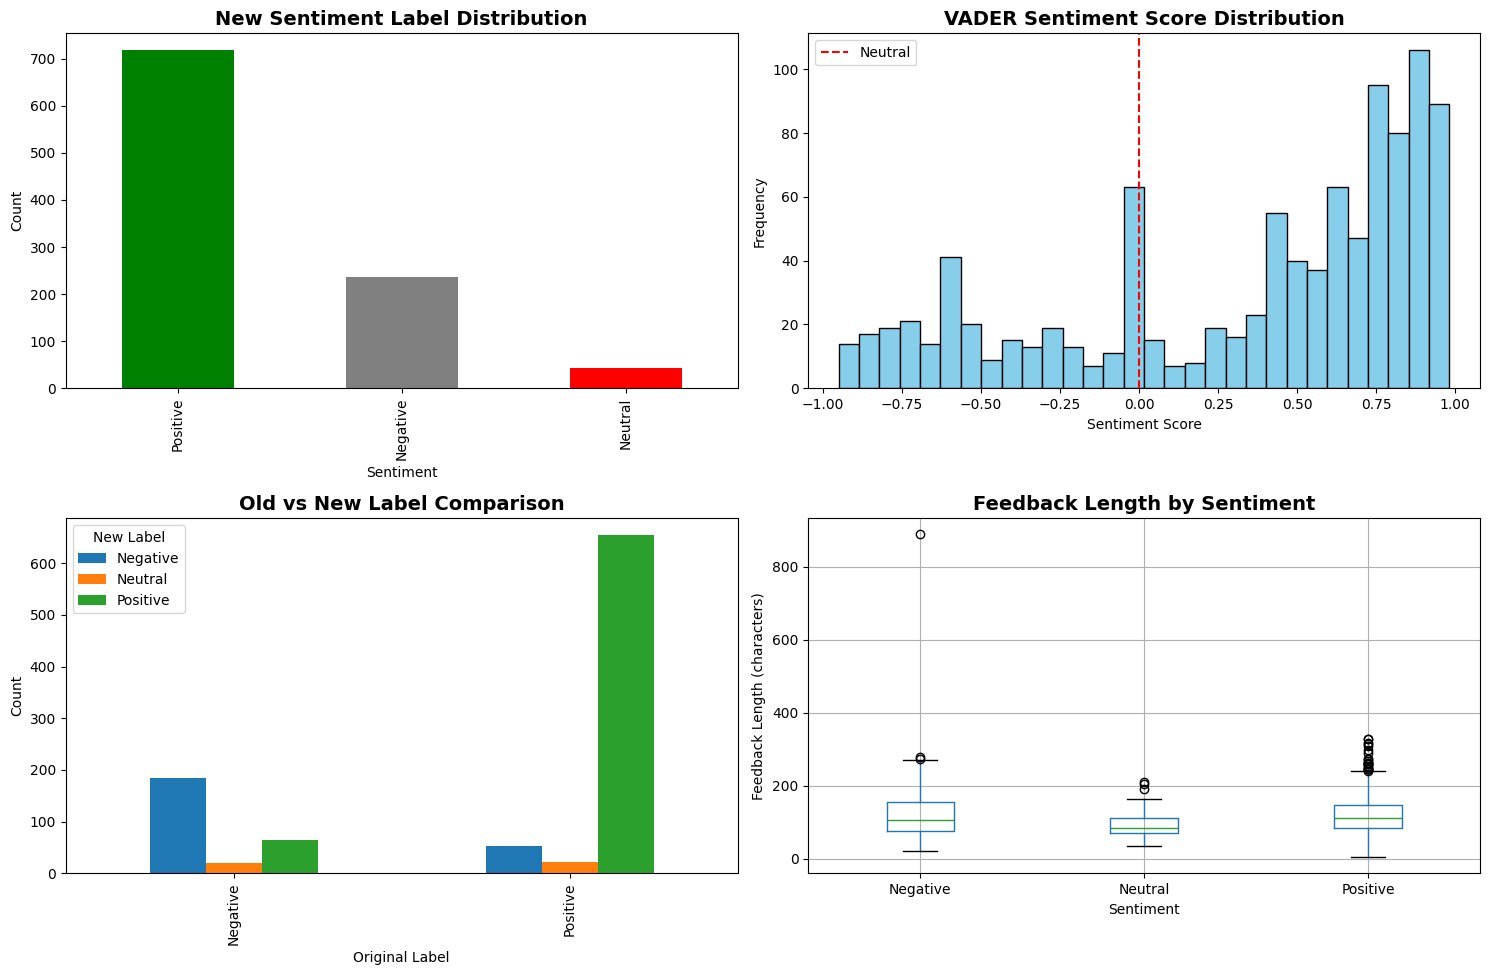

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: New Sentiment Distribution
df['New_Sentiment'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'gray', 'red'])
axes[0, 0].set_title('New Sentiment Label Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sentiment')
axes[0, 0].set_ylabel('Count')

# Plot 2: Sentiment Score Distribution (VADER)
axes[0, 1].hist(df['VADER_Score'], bins=30, color='skyblue', edgecolor='black')
axes[0, 1].set_title('VADER Sentiment Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(x=0, color='red', linestyle='--', label='Neutral')
axes[0, 1].legend()

# Plot 3: Old vs New Label Comparison
comparison_df = pd.DataFrame({
    'Old_Label': df['Sentiment Label'].map({0: 'Negative', 1: 'Positive'}),
    'New_Label': df['New_Sentiment']
})
comparison_counts = comparison_df.groupby(['Old_Label', 'New_Label']).size().unstack(fill_value=0)
comparison_counts.plot(kind='bar', ax=axes[1, 0], stacked=False)
axes[1, 0].set_title('Old vs New Label Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Original Label')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='New Label')

# Plot 4: Feedback Length Distribution by Sentiment
df['Feedback_Length'] = df['Feedback'].str.len()
df.boxplot(column='Feedback_Length', by='New_Sentiment', ax=axes[1, 1])
axes[1, 1].set_title('Feedback Length by Sentiment', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Feedback Length (characters)')
plt.suptitle('')

plt.tight_layout()
plt.savefig('sentiment_analysis_overview.png', dpi=300, bbox_inches='tight')
plt.show()

# STEP 6: MANUAL VALIDATION SAMPLE

In [20]:
# Sample some from each category for manual review
sample_size = 5
for sentiment in ['Positive', 'Negative', 'Neutral']:
    print(f"\n--- {sentiment.upper()} SAMPLES ---")
    samples = df[df['New_Sentiment'] == sentiment].sample(min(sample_size, len(df[df['New_Sentiment'] == sentiment])))
    for idx, row in samples.iterrows():
        print(f"\n{idx}. Feedback: {row['Feedback'][:150]}...")
        print(f"   Label: {row['New_Sentiment']} (Score: {row['VADER_Score']:.3f})")



--- POSITIVE SAMPLES ---

116. Feedback: Happy to get treated by Dr Vivek Belathur ,the best oncologist in Bangalore. His care to his patient is wonderful....
   Label: Positive (Score: 0.941)

544. Feedback: One of the rare hospital brands in bangalore which still keep the dignity of this profession The hospital management system is efficient and the staff...
   Label: Positive (Score: 0.863)

246. Feedback: Visited the medical oncology department The consultation process was smooth Staff were polite and helpful....
   Label: Positive (Score: 0.421)

234. Feedback: Overall it is a good and clean hospital which makes it one of the most favorite hospitals for locals and international patients....
   Label: Positive (Score: 0.836)

238. Feedback: My experience with the hospital was good overall....
   Label: Positive (Score: 0.440)

--- NEGATIVE SAMPLES ---

530. Feedback: Treatment and other services are good They will charge more for emergency services during night In house canteen fo

# STEP 7: SAVE CLEANED DATASET

In [21]:
# Keep relevant columns
df_final = df[['Feedback', 'Feedback_Clean', 'New_Sentiment', 'Sentiment_Numeric',
               'VADER_Score', 'TextBlob_Score', 'Feedback_Length']]

# Save to CSV
df_final.to_csv('hospital_feedback_cleaned.csv', index=False)

In [22]:
print("\n" + "="*60)
print("DATASET SAVED")
print("="*60)
print(f"\nCleaned dataset saved as 'hospital_feedback_cleaned.csv'")
print(f"Total records: {len(df_final)}")
print(f"\nColumns in cleaned dataset:")
for col in df_final.columns:
    print(f"  - {col}")


DATASET SAVED

Cleaned dataset saved as 'hospital_feedback_cleaned.csv'
Total records: 996

Columns in cleaned dataset:
  - Feedback
  - Feedback_Clean
  - New_Sentiment
  - Sentiment_Numeric
  - VADER_Score
  - TextBlob_Score
  - Feedback_Length


# STEP 8: SENTIMENT MODEL

In [23]:
# Remove neutral for binary classification (optional)
df_binary = df_final[df_final['New_Sentiment'].isin(['Positive', 'Negative'])].copy()
df_binary['Sentiment_Binary'] = df_binary['New_Sentiment'].map({'Positive': 1, 'Negative': 0})

In [24]:
# Split data
X = df_binary['Feedback_Clean']
y = df_binary['Sentiment_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Vectorize
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [26]:
import joblib
joblib.dump(vectorizer, 'vectorizer_sentiment.pkl')

['vectorizer_sentiment.pkl']

In [ ]:
# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Evaluate
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(f"\nModel Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))



Model Accuracy: 75.92%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.21      0.34        56
    Positive       0.75      0.99      0.85       135

    accuracy                           0.76       191
   macro avg       0.80      0.60      0.60       191
weighted avg       0.78      0.76      0.70       191



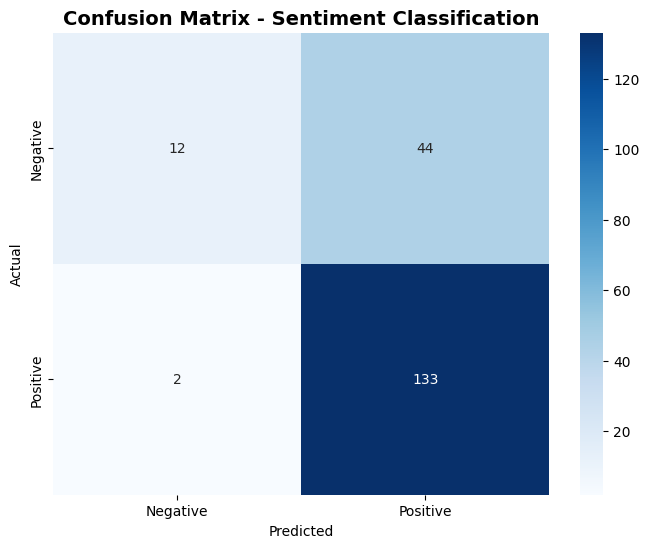

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Sentiment Classification', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import joblib
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']

# QA INSIGHT GENERATOR - HOSPITAL FEEDBACK ANALYSIS

In [ ]:
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/hospital_feedback_cleaned.csv')

# 1. ASPECT/CATEGORY EXTRACTION

In [ ]:
# Define categories and their keywords
category_keywords = {
    'Staff Behavior': ['staff', 'nurse', 'doctor', 'rude', 'helpful', 'friendly', 'professional',
                       'attitude', 'behavior', 'personnel', 'team', 'receptionist'],
    'Wait Time': ['wait', 'waiting', 'delay', 'queue', 'appointment', 'time', 'hours',
                  'scheduled', 'punctual', 'late', 'quick', 'slow'],
    'Cleanliness': ['clean', 'dirty', 'hygiene', 'sanitize', 'washroom', 'bathroom',
                    'tidy', 'neat', 'mess', 'spotless'],
    'Facilities': ['facility', 'equipment', 'room', 'bed', 'building', 'infrastructure',
                   'amenities', 'cafeteria', 'parking', 'elevator'],
    'Treatment Quality': ['treatment', 'diagnosis', 'care', 'medical', 'procedure',
                          'surgery', 'therapy', 'medication', 'recovery'],
    'Billing/Cost': ['bill', 'cost', 'price', 'expensive', 'charge', 'payment',
                     'insurance', 'affordable', 'money', 'fee'],
    'Communication': ['communicate', 'explain', 'information', 'language', 'understand',
                      'clear', 'confusing', 'informed', 'update'],
    'Emergency Services': ['emergency', 'urgent', 'ambulance', 'critical', '911', 'trauma']}

In [ ]:
def categorize_feedback(text):
    """Assign feedback to categories based on keywords"""
    if not isinstance(text, str):
        return []

    text_lower = text.lower()
    categories = []

    for category, keywords in category_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            categories.append(category)

    return categories if categories else ['General']

# Apply categorization
df['Categories'] = df['Feedback'].apply(categorize_feedback)

In [ ]:
# Explode to have one row per category
df_exploded = df.explode('Categories')

# 2. KEY INSIGHT 1: COMPLAINT DISTRIBUTION

In [ ]:
# Get negative feedback by category
negative_feedback = df_exploded[df_exploded['New_Sentiment'] == 'Negative']
complaint_dist = negative_feedback['Categories'].value_counts()

print("\nNegative Feedback Distribution:")
for category, count in complaint_dist.items():
    percentage = (count / len(negative_feedback)) * 100
    print(f"  🔴 {category:.<30} {count:>4} ({percentage:.1f}%)")


Negative Feedback Distribution:
  🔴 Staff Behavior................   95 (25.5%)
  🔴 Billing/Cost..................   69 (18.5%)
  🔴 Wait Time.....................   56 (15.0%)
  🔴 General.......................   51 (13.7%)
  🔴 Treatment Quality.............   29 (7.8%)
  🔴 Emergency Services............   29 (7.8%)
  🔴 Facilities....................   26 (7.0%)
  🔴 Cleanliness...................   12 (3.2%)
  🔴 Communication.................    6 (1.6%)


In [ ]:
# Find top complaint
if len(complaint_dist) > 0:
    top_complaint = complaint_dist.index[0]
    top_complaint_pct = (complaint_dist.iloc[0] / len(negative_feedback)) * 100
    print(f"\n💡 KEY INSIGHT: Most complaints are about '{top_complaint}' ({top_complaint_pct:.1f}% of negative feedback)")


💡 KEY INSIGHT: Most complaints are about 'Staff Behavior' (25.5% of negative feedback)


# 3. KEY INSIGHT 2: POSITIVE HIGHLIGHTS

In [ ]:
positive_feedback = df_exploded[df_exploded['New_Sentiment'] == 'Positive']
positive_dist = positive_feedback['Categories'].value_counts()

print("\nPositive Feedback Distribution:")
for category, count in positive_dist.head(5).items():
    percentage = (count / len(positive_feedback)) * 100
    print(f"  🟢 {category:.<30} {count:>4} ({percentage:.1f}%)")


Positive Feedback Distribution:
  🟢 Staff Behavior................  397 (35.9%)
  🟢 Treatment Quality.............  252 (22.8%)
  🟢 General.......................  111 (10.0%)
  🟢 Wait Time.....................  110 (9.9%)
  🟢 Billing/Cost..................   79 (7.1%)


In [ ]:
if len(positive_dist) > 0:
    top_positive = positive_dist.index[0]
    top_positive_pct = (positive_dist.iloc[0] / len(positive_feedback)) * 100
    print(f"\n💡 KEY INSIGHT: Patients most appreciate '{top_positive}' ({top_positive_pct:.1f}% of positive feedback)")


💡 KEY INSIGHT: Patients most appreciate 'Staff Behavior' (35.9% of positive feedback)


# 4. KEY INSIGHT 3: CRITICAL ISSUES

In [ ]:
# Calculate sentiment ratio for each category
category_sentiment = df_exploded.groupby(['Categories', 'New_Sentiment']).size().unstack(fill_value=0)

In [ ]:
# Calculate negative percentage
if 'Negative' in category_sentiment.columns:
    category_sentiment['Negative_Pct'] = (category_sentiment['Negative'] /
                                          category_sentiment.sum(axis=1) * 100)
    critical_areas = category_sentiment.sort_values('Negative_Pct', ascending=False).head(5)

    print("\nCategories with Highest Negative Sentiment:")
    for idx, row in critical_areas.iterrows():
        print(f"  ⚠️  {idx:.<30} {row['Negative_Pct']:.1f}% negative")

    print(f"\n💡 KEY INSIGHT: '{critical_areas.index[0]}' has the highest negative sentiment rate ({critical_areas['Negative_Pct'].iloc[0]:.1f}%)")



Categories with Highest Negative Sentiment:
  ⚠️  Emergency Services............ 61.7% negative
  ⚠️  Billing/Cost.................. 45.1% negative
  ⚠️  Facilities.................... 36.1% negative
  ⚠️  Wait Time..................... 31.3% negative
  ⚠️  General....................... 29.1% negative

💡 KEY INSIGHT: 'Emergency Services' has the highest negative sentiment rate (61.7%)


# 5. KEY INSIGHT 4: KEYWORD ANALYSIS

In [ ]:
# Extract common words from negative feedback
negative_text = ' '.join(df[df['New_Sentiment'] == 'Negative']['Feedback_Clean'].dropna())

# Remove common words
stop_words = set(['when','the', 'and', 'was', 'for', 'are', 'but', 'not', 'with', 'this', 'that',
                  'from', 'they', 'have', 'been', 'were', 'had', 'there', 'their', 'very'])

words = [word for word in negative_text.split() if word not in stop_words and len(word) > 3]
word_freq = Counter(words).most_common(15)

print("\nTop Words in Negative Feedback:")
for word, count in word_freq:
    print(f"  🔑 {word:.<20} {count:>4} times")


Top Words in Negative Feedback:
  🔑 hospital............   91 times
  🔑 worst...............   72 times
  🔑 experience..........   45 times
  🔑 staff...............   41 times
  🔑 doctor..............   39 times
  🔑 patient.............   34 times
  🔑 emergency...........   34 times
  🔑 dont................   26 times
  🔑 patients............   26 times
  🔑 will................   25 times
  🔑 service.............   22 times
  🔑 good................   22 times
  🔑 even................   21 times
  🔑 money...............   19 times
  🔑 time................   17 times


# 6. SIMULATED TREND ANALYSIS

In [ ]:
# For simulation: divide data into quarters
df['Quarter'] = pd.cut(range(len(df)), bins=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Calculate sentiment distribution per quarter
quarter_sentiment = df.groupby(['Quarter', 'New_Sentiment']).size().unstack(fill_value=0)

if 'Negative' in quarter_sentiment.columns:
    quarter_sentiment['Negative_Pct'] = (quarter_sentiment['Negative'] /
                                         quarter_sentiment.sum(axis=1) * 100)

    print("\nQuarterly Sentiment Trend:")
    for quarter in quarter_sentiment.index:
        neg_pct = quarter_sentiment.loc[quarter, 'Negative_Pct']
        pos_pct = (quarter_sentiment.loc[quarter, 'Positive'] /
                   quarter_sentiment.loc[quarter].sum() * 100) if 'Positive' in quarter_sentiment.columns else 0
        print(f"  📅 {quarter}: {neg_pct:.1f}% negative, {pos_pct:.1f}% positive")

    # Calculate trend
    q1_neg = quarter_sentiment.iloc[0]['Negative_Pct']
    q4_neg = quarter_sentiment.iloc[-1]['Negative_Pct']
    trend_change = q4_neg - q1_neg

    if trend_change > 0:
        print(f"\n💡 KEY INSIGHT: Dissatisfaction INCREASED by {abs(trend_change):.1f}% from Q1 to Q4 ⚠️")
    else:
        print(f"\n💡 KEY INSIGHT: Dissatisfaction DECREASED by {abs(trend_change):.1f}% from Q1 to Q4 ✅")


Quarterly Sentiment Trend:
  📅 Q1: 17.3% negative, 72.9% positive
  📅 Q2: 23.3% negative, 66.8% positive
  📅 Q3: 33.3% negative, 55.3% positive
  📅 Q4: 20.9% negative, 68.9% positive

💡 KEY INSIGHT: Dissatisfaction INCREASED by 3.6% from Q1 to Q4 ⚠️


# 7. PRIORITY MATRIX

In [ ]:
# Calculate impact (volume) and severity (negative %)
category_analysis = df_exploded.groupby('Categories').agg({
    'New_Sentiment': lambda x: (x == 'Negative').sum(),
    'Feedback': 'count'
}).rename(columns={'New_Sentiment': 'Negative_Count', 'Feedback': 'Total_Count'})

category_analysis['Negative_Pct'] = (category_analysis['Negative_Count'] /
                                     category_analysis['Total_Count'] * 100)
category_analysis['Impact_Score'] = (category_analysis['Total_Count'] *
                                     category_analysis['Negative_Pct'] / 100)

# Sort by impact score
priority_categories = category_analysis.sort_values('Impact_Score', ascending=False).head(5)

print("\nPriority Categories (High Impact + High Severity):")
print(f"{'Category':<25} {'Volume':<10} {'Neg %':<10} {'Impact Score':<15}")
print("-" * 60)
for idx, row in priority_categories.iterrows():
    print(f"{idx:<25} {int(row['Total_Count']):<10} {row['Negative_Pct']:.1f}%{'':<6} {row['Impact_Score']:.1f}")

print(f"\n💡 KEY INSIGHT: Focus QA efforts on '{priority_categories.index[0]}' - highest impact on patient satisfaction")


Priority Categories (High Impact + High Severity):
Category                  Volume     Neg %      Impact Score   
------------------------------------------------------------
Staff Behavior            505        18.8%       95.0
Billing/Cost              153        45.1%       69.0
Wait Time                 179        31.3%       56.0
General                   175        29.1%       51.0
Emergency Services        47         61.7%       29.0

💡 KEY INSIGHT: Focus QA efforts on 'Staff Behavior' - highest impact on patient satisfaction


# 8. ACTIONABLE RECOMMENDATIONS

In [ ]:
recommendations = []

# Based on top complaint
if len(complaint_dist) > 0:
    top_cat = complaint_dist.index[0]
    recommendations.append(f"1. IMMEDIATE: Address '{top_cat}' issues - {complaint_dist.iloc[0]} complaints recorded")

# Based on trend
if 'trend_change' in locals() and trend_change > 5:
    recommendations.append(f"2. URGENT: Overall dissatisfaction rising - implement intervention plan")

# Based on critical areas
if 'critical_areas' in locals() and len(critical_areas) > 0:
    worst_cat = critical_areas.index[0]
    recommendations.append(f"3. HIGH PRIORITY: '{worst_cat}' has {critical_areas['Negative_Pct'].iloc[0]:.1f}% negative rate - needs review")

# Based on volume
high_volume = category_analysis.nlargest(1, 'Total_Count')
if len(high_volume) > 0:
    recommendations.append(f"4. MONITOR: '{high_volume.index[0]}' receives most feedback - track closely")

# Based on keywords
if len(word_freq) > 0:
    top_word = word_freq[0][0]
    recommendations.append(f"5. INVESTIGATE: Word '{top_word}' appears {word_freq[0][1]} times in complaints")

for rec in recommendations:
    print(f"\n  ✅ {rec}")


  ✅ 1. IMMEDIATE: Address 'Staff Behavior' issues - 95 complaints recorded

  ✅ 3. HIGH PRIORITY: 'Emergency Services' has 61.7% negative rate - needs review

  ✅ 4. MONITOR: 'Staff Behavior' receives most feedback - track closely

  ✅ 5. INVESTIGATE: Word 'hospital' appears 91 times in complaints


# 9. VISUALIZATIONS

✅ Dashboard saved as 'qa_insights_dashboard.png'


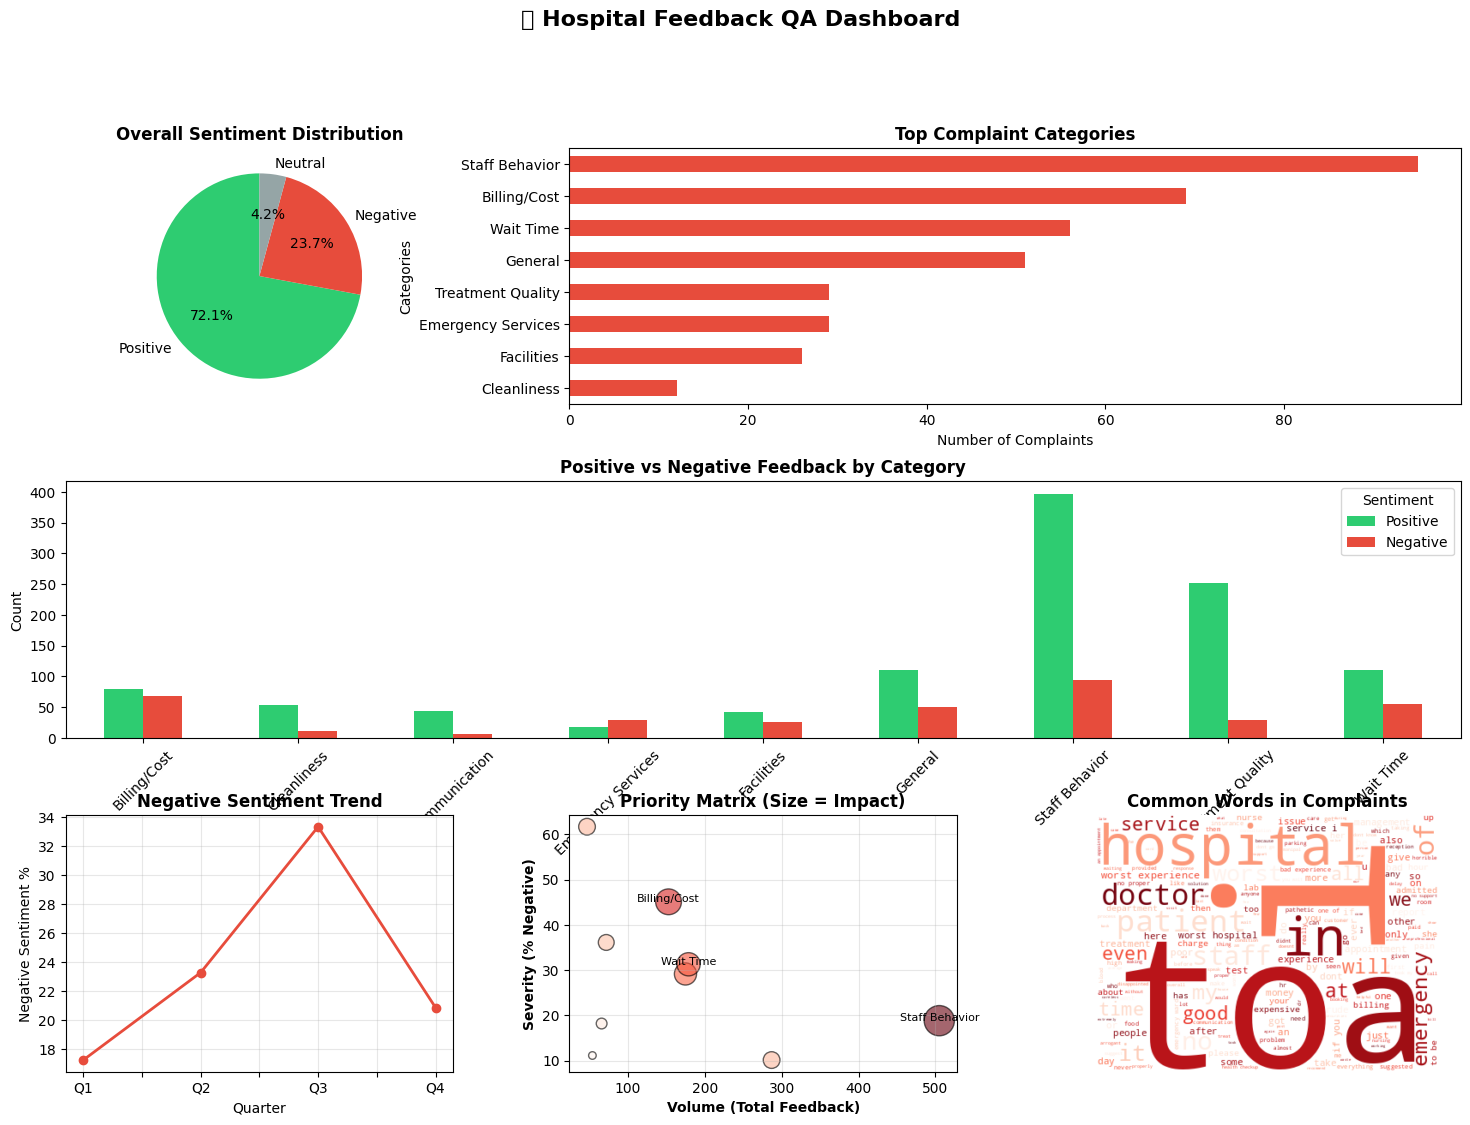

In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Overall Sentiment Distribution
ax1 = fig.add_subplot(gs[0, 0])
sentiment_counts = df['New_Sentiment'].value_counts()
colors = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#95a5a6'}
ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=[colors.get(x, '#34495e') for x in sentiment_counts.index],
        startangle=90)
ax1.set_title('Overall Sentiment Distribution', fontweight='bold', fontsize=12)

# Plot 2: Category-wise Complaint Distribution
ax2 = fig.add_subplot(gs[0, 1:])
complaint_dist.head(8).plot(kind='barh', ax=ax2, color='#e74c3c')
ax2.set_title('Top Complaint Categories', fontweight='bold', fontsize=12)
ax2.set_xlabel('Number of Complaints')
ax2.invert_yaxis()

# Plot 3: Positive vs Negative by Category
ax3 = fig.add_subplot(gs[1, :])
category_comparison = df_exploded.groupby(['Categories', 'New_Sentiment']).size().unstack(fill_value=0)
if 'Positive' in category_comparison.columns and 'Negative' in category_comparison.columns:
    category_comparison[['Positive', 'Negative']].plot(kind='bar', ax=ax3,
                                                        color=['#2ecc71', '#e74c3c'])
ax3.set_title('Positive vs Negative Feedback by Category', fontweight='bold', fontsize=12)
ax3.set_xlabel('Category')
ax3.set_ylabel('Count')
ax3.legend(title='Sentiment')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Trend Analysis
ax4 = fig.add_subplot(gs[2, 0])
if 'Negative_Pct' in quarter_sentiment.columns:
    quarter_sentiment['Negative_Pct'].plot(kind='line', ax=ax4, marker='o',
                                           color='#e74c3c', linewidth=2)
ax4.set_title('Negative Sentiment Trend', fontweight='bold', fontsize=12)
ax4.set_xlabel('Quarter')
ax4.set_ylabel('Negative Sentiment %')
ax4.grid(True, alpha=0.3)

# Plot 5: Priority Matrix
ax5 = fig.add_subplot(gs[2, 1])
scatter_data = category_analysis.reset_index()
scatter = ax5.scatter(scatter_data['Total_Count'], scatter_data['Negative_Pct'],
                     s=scatter_data['Impact_Score']*5, alpha=0.6, c=scatter_data['Impact_Score'],
                     cmap='Reds', edgecolors='black', linewidth=1)
ax5.set_xlabel('Volume (Total Feedback)', fontweight='bold')
ax5.set_ylabel('Severity (% Negative)', fontweight='bold')
ax5.set_title('Priority Matrix (Size = Impact)', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)

# Annotate top 3
for idx, row in scatter_data.nlargest(3, 'Impact_Score').iterrows():
    ax5.annotate(row['Categories'][:15],
                (row['Total_Count'], row['Negative_Pct']),
                fontsize=8, ha='center')

# Plot 6: Word Cloud for Negative Feedback
ax6 = fig.add_subplot(gs[2, 2])
if negative_text:
    wordcloud = WordCloud(width=400, height=300, background_color='white',
                         colormap='Reds', stopwords=stop_words).generate(negative_text)
    ax6.imshow(wordcloud, interpolation='bilinear')
    ax6.axis('off')
    ax6.set_title('Common Words in Complaints', fontweight='bold', fontsize=12)

plt.suptitle('🏥 Hospital Feedback QA Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('qa_insights_dashboard.png', dpi=300, bbox_inches='tight')
print("✅ Dashboard saved as 'qa_insights_dashboard.png'")
plt.show()

# 10. EXPORT INSIGHTS REPORT

In [ ]:
# Create detailed report CSV
report_data = {
    'Category': [],
    'Total_Feedback': [],
    'Positive_Count': [],
    'Negative_Count': [],
    'Neutral_Count': [],
    'Negative_Percentage': [],
    'Priority_Level': []
}

for category in category_analysis.index:
    cat_data = df_exploded[df_exploded['Categories'] == category]
    sentiment_counts = cat_data['New_Sentiment'].value_counts()

    total = len(cat_data)
    positive = sentiment_counts.get('Positive', 0)
    negative = sentiment_counts.get('Negative', 0)
    neutral = sentiment_counts.get('Neutral', 0)
    neg_pct = (negative / total * 100) if total > 0 else 0

    # Assign priority
    if neg_pct > 50 and total > 10:
        priority = 'HIGH'
    elif neg_pct > 30 and total > 5:
        priority = 'MEDIUM'
    else:
        priority = 'LOW'

    report_data['Category'].append(category)
    report_data['Total_Feedback'].append(total)
    report_data['Positive_Count'].append(positive)
    report_data['Negative_Count'].append(negative)
    report_data['Neutral_Count'].append(neutral)
    report_data['Negative_Percentage'].append(round(neg_pct, 2))
    report_data['Priority_Level'].append(priority)

report_df = pd.DataFrame(report_data).sort_values('Negative_Percentage', ascending=False)
report_df.to_csv('qa_insights_report.csv', index=False)

print("✅ Detailed report saved as 'qa_insights_report.csv'")
print(f"\nSummary:")
print(f"  • {len(report_df)} categories analyzed")
print(f"  • {len(report_df[report_df['Priority_Level'] == 'HIGH'])} high-priority areas identified")
print(f"  • {len(report_df[report_df['Priority_Level'] == 'MEDIUM'])} medium-priority areas identified")

print("\n" + "="*80)
print("✨ ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("  1. qa_insights_dashboard.png - Visual dashboard")
print("  2. qa_insights_report.csv - Detailed category-wise report")
print("\nNext Steps:")
print("  • Share insights with department heads")
print("  • Create action plans for high-priority categories")
print("  • Set up monitoring for trending issues")
print("  • Schedule follow-up analysis in 30 days")

✅ Detailed report saved as 'qa_insights_report.csv'

Summary:
  • 9 categories analyzed
  • 1 high-priority areas identified
  • 3 medium-priority areas identified

✨ ANALYSIS COMPLETE!

Generated Files:
  1. qa_insights_dashboard.png - Visual dashboard
  2. qa_insights_report.csv - Detailed category-wise report

Next Steps:
  • Share insights with department heads
  • Create action plans for high-priority categories
  • Set up monitoring for trending issues
  • Schedule follow-up analysis in 30 days
